# Convergence of training and test error

According to statistical learning theory:
* Training and test errors converge when the number of training samples grows for all **reasonable machine learning methods**. 

However, the convergence speeds really depends on many factors. The following notebook highlights the differences and causes behind them.    

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd

from pandas import Series
from pandas import DataFrame
from typing import List

# Local imports
from common import *
from convenience import *

## I. Data generation functions 

Code for generating data according to logistic regression model:

* The binary data matrix X is generated randomly.
* The target vector y is generated according to logit model.

We generate two types of data matrices:

* compact matrices where all features are needed for prediction,
* matrices with redundant columns that do not contain any information for prediction.

**Random functions** 

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def logit(x:Series, w:Series):
    """
    Randomly labels output according to logit model pr[y=1|sigmoid(w*x)]
    
    You can omit trailing zeroes in w by specifying only first non-zero coefficients  
    """
    return random.rand() <= sigmoid(np.dot(x.iloc[0:len(w)] - 0.5, w))

**Data generation**

In [3]:
def data_sampler(n:int, k:int,  f:callable) -> DataFrame:
    """
    Data generator that generates n x k feature matrix and a target vector
    
    Returns a data frame with columns x_1, ..., x_k, y where y is computed
    using randomised labelling function f.
    """
    
    columns = ['x_{}'.format(num) for num in range(1, k + 1)]
    return (DataFrame(random.rand(n, k), columns = columns)
            .transform(lambda x: x >= 0.5)
            .assign(y = lambda df: df.apply(f, axis=1)))

## II. Example datasets

* The size of the dataset and nature of the labelling function determine the difficulty of the problem.
* If the target function is near-deterministic then there exists a good predictor.
* If the number of features is small then it is easier to learn the target function.
* **Clarification:** Target function is a perfect mathematical model of the actual process that maps features to labels.

###  Choosing among target functions

* Let's build a target function that outputs `True` if at least one input is `True`.
* The weights `w = [1, 1]` achieve this most of the time. Still the relation does not always hold.
* Larger weights `[10, 10]` increase certainty and smaller weights `[0.1, 0.1]` decrease certainty.
* **Clarification:** Certainty quantifies whether the result occurs always or the outcome is random.  

In [4]:
fs = lambda x: logit(x, Series([1, 1]))
X = data_sampler(1000, 2, fs)
X.head()

,x_1,x_2,y
0,False,False,True
1,True,True,True
2,True,False,True
3,True,False,False
4,True,False,True


Let see what is the fraction of `True` values for each input

In [5]:
S = X.groupby(['x_1', 'x_2']).aggregate(['count', 'sum'])
S.columns = S.columns.droplevel(0)  
S = S.assign(freq = lambda df: round(df['sum']/df['count'] * 100))
S.reset_index()

,x_1,x_2,count,sum,freq
0,False,False,244,60,25.0
1,False,True,275,141,51.0
2,True,False,241,108,45.0
3,True,True,240,177,74.0


The relation between inputs and output is not so clear:
* Let's experiment with different weights to see what happens.
* For simplicity, let's convert the previous analysis to a function.

In [6]:
def summarize(X:DataFrame) -> DataFrame:
    S = X.groupby(['x_1', 'x_2']).aggregate(['count', 'sum'])
    S.columns = S.columns.droplevel(0)  
    return (S.assign(freq = lambda df: round(df['sum']/df['count'] * 100)).
            reset_index())  
display(summarize(X))

,x_1,x_2,count,sum,freq
0,False,False,244,60,25.0
1,False,True,275,141,51.0
2,True,False,241,108,45.0
3,True,True,240,177,74.0


To estimate the effect of statistical fluctuations we do two experiments and compare results.

In [7]:
X = data_sampler(1000, 2, lambda x: logit(x, Series([10, 10])))
S1 = summarize(X)
X = data_sampler(1000, 2, lambda x: logit(x, Series([10, 10])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

X = data_sampler(1000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S1 = summarize(X)
X = data_sampler(1000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 246 
 0 
 0.0 
 
 
 False 
 True 
 258 
 125 
 48.0 
 
 
 True 
 False 
 251 
 131 
 52.0 
 
 
 True 
 True 
 245 
 245 
 100.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 243 
 0 
 0.0 
 
 
 False 
 True 
 259 
 132 
 51.0 
 
 
 True 
 False 
 254 
 131 
 52.0 
 
 
 True 
 True 
 244 
 244 
 100.0

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 257 
 130 
 51.0 
 
 
 False 
 True 
 270 
 126 
 47.0 
 
 
 True 
 False 
 222 
 112 
 50.0 
 
 
 True 
 True 
 251 
 141 
 56.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 242 
 110 
 45.0 
 
 
 False 
 True 
 250 
 118 
 47.0 
 
 
 True 
 False 
 249 
 132 
 53.0 
 
 
 True 
 True 
 259 
 130 
 50.0

**Conclusion:** The number of samples is too small to get an accurate probability estimate.

In [8]:
X = data_sampler(100000, 2, lambda x: logit(x, Series([10, 10])))
S1 = summarize(X)
X = data_sampler(100000, 2, lambda x: logit(x, Series([10, 10])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

X = data_sampler(100000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S1 = summarize(X)
X = data_sampler(100000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25212 
 1 
 0.0 
 
 
 False 
 True 
 25020 
 12519 
 50.0 
 
 
 True 
 False 
 24836 
 12480 
 50.0 
 
 
 True 
 True 
 24932 
 24932 
 100.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25267 
 1 
 0.0 
 
 
 False 
 True 
 25055 
 12638 
 50.0 
 
 
 True 
 False 
 24862 
 12399 
 50.0 
 
 
 True 
 True 
 24816 
 24816 
 100.0

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25104 
 11886 
 47.0 
 
 
 False 
 True 
 24960 
 12597 
 50.0 
 
 
 True 
 False 
 24932 
 12376 
 50.0 
 
 
 True 
 True 
 25004 
 13189 
 53.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25105 
 11902 
 47.0 
 
 
 False 
 True 
 24934 
 12614 
 51.0 
 
 
 True 
 False 
 24918 
 12553 
 50.0 
 
 
 True 
 True 
 25043 
 13232 
 53.0

* Weight vector `w = [10, 10]` creates predictable instances.
* Weight vector `w = [0.1, 0.1]` creates almost unpredictable instances.

### Choosing learning tasks to compare

* Let's experiment with predictable and almost unpredictable labelling functions.
* Let's experiment with small and big number of features.

In [9]:
sampler_11 = lambda n: data_sampler(n, 2, lambda x: logit(x, Series([10, 10])))
sampler_10 = lambda n: data_sampler(n, 2, lambda x: logit(x, Series([0.1, 0.1])))
sampler_01 = lambda n: data_sampler(n, 15, lambda x: logit(x, Series([10, 10])))
sampler_00 = lambda n: data_sampler(n, 15, lambda x: logit(x, Series([0.1, 0.1])))

## III. Learning algorithms

* Let's observe the behaviour of several algorithms.
* Majority voting is the simplest and the best classification algorithm:
  * It is optimal if the number of samples is large enough to cover each possible input.
  * It is theoretically optimal – we cannot do better without extra knowledge about the data.
* Logistic regression can work with fewer samples:
  * It makes extra assumptions about the labelling function.
  * As a result, there are fewer parameters to learn.
  * The convergence to the final classification algorithm is faster.

### The best theoretical  fit  
* As the data is generated by logit function the target function is in the model class of logistic regression.
* That is there is a vector of coefficients for the logistic regression that represents the target function if we also consider the noise parameters.
* Majority voting cannot trully represent the target function as it always outputs a deterministic function and there is no noise estimation. 
* The best predictor for the target function is among the functions the majority voting algorithm can produce.
* The best predictor for the target function is among the functions the logistic regression algorithm can produce if we ignore noise parameters.
    

###  Majority voting algorithm

* Our implementation corresponds to `sklearn` prediction API:
  * constructor for fixing free hyperparameters
  * method `fit(samples, targets)` to train the model
  * method `predict(samples)` to predict labels
  * method `set_params(...)` to set hyperparameters  

In [10]:
class MajorityVoting:
    
    def __init__(self, features:List[str]=None):
        if features:
            self.features = list(features)
        else:
            self.features = None
    
    def set_params(features: List[str]) -> None:
        self.features = features
    
    def fit(self, X: DataFrame, y: Series) -> None:
        
        if self.features is None:
            self.features = list(X.columns.values)

        data = X.assign(y = y)
        pred = data.groupby(self.features).aggregate(['count', 'sum'])
        pred.columns = pred.columns.droplevel(0)
        self.pred = DataFrame({'prediction':(pred['sum']/pred['count'] >= 0.5)})
    
    def predict(self, X: DataFrame) -> np.array:
        
        return (X[self.features]
                .join(self.pred, on=self.features, how='left')['prediction']
                .fillna(True)
                .values)

**Majority voting:** example run

In [11]:
clf = MajorityVoting()
data = sampler_11(2)
features = list(data.columns.values)[0:-1]
clf.fit(data[features], data['y'])
mdisplay([data, clf.pred],['Data', 'Predictor'])

Data Predictor 
 
 
 x_1 
 x_2 
 y 
 
 
 
 
 True 
 False 
 True 
 
 
 False 
 False 
 False 
 
 
 
 
 
 prediction 
 
 
 
 
 False 
 
 
 True

**Logistic regression:** example run

* The example below could fail if the generated 2-instances dataset has only one unique label. 
* To see output of this cell correctly, you can rerun this cell until no errors are thrown.

In [12]:
from sklearn.linear_model import LogisticRegression
data = sampler_11(2)

clf = LogisticRegression(solver = 'lbfgs')
features = list(data.columns.values)[0:-1]
clf.fit(data[features], data['y'])
clf.predict(data[features])

array([False,  True])

## IV.  Convergence plots for accuracy

* We generate different datasets of different sizes and estimate classifiers' performance on the test set.
* To eliminate fluctuations based on test data generation, we use the same testset for all training set sizes.

### Generation of training and test data

In [13]:
sizes = [10, 50, 100] + list(range(200, 1001, 100)) + list(range(2000, 5001, 1000))

train_00 = [sampler_00(n) for n in sizes]
features_00 = list(train_00[0].columns.values[0:-1])

train_01 = [sampler_01(n) for n in sizes]
features_01 = list(train_01[0].columns.values[0:-1])

train_10 = [sampler_10(n) for n in sizes]
features_10 = list(train_10[0].columns.values[0:-1])

train_11 = [sampler_11(n) for n in sizes]
features_11 = list(train_11[0].columns.values[0:-1])

n = 10000
test_00 = sampler_00(n)
test_01 = sampler_01(n)
test_10 = sampler_10(n)
test_11 = sampler_11(n)

### Majority Voting example  

To work out the details, it is always easier to do the analysis for one dataset.

In [14]:
test = test_11
train = train_11[1]
clf = MajorityVoting(features_11)
clf.fit(train, train['y'])
display(clf.pred)

prediction
x_1   x_2              
False False       False
      True         True
True  False        True
      True         True

In [15]:
mdisplay([train.head(), DataFrame(clf.predict(train)).head()], ['Data', 'Prediction'])

Data Prediction 
 
 
 x_1 
 x_2 
 y 
 
 
 
 
 False 
 True 
 False 
 
 
 False 
 False 
 False 
 
 
 True 
 True 
 True 
 
 
 False 
 False 
 False 
 
 
 False 
 False 
 False 
 
 
 
 
 
 0 
 
 
 
 
 True 
 
 
 False 
 
 
 True 
 
 
 False 
 
 
 False

In [16]:
test_error = sum(test['y'] != clf.predict(test)) / len(test) * 100
training_error = sum(train['y'] != clf.predict(train)) / len(train) * 100
print('Training error: {tr}% \nTest error:     {te}%'.format(tr=round(training_error), te=round(test_error)))

Training error: 20% 
Test error:     25%


### Logistic regression example

In [17]:
test = test_11
train = train_11[1]
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(train[features_11], train['y'])

LogisticRegression()

In [18]:
test_error = sum(test['y'] != clf.predict(test[features_11])) / len(test) * 100
training_error = sum(train['y'] != clf.predict(train[features_11])) / len(train) * 100
print('Training error: {tr}% \nTest error:     {te}%'.format(tr=round(training_error), te=round(test_error)))

Training error: 20% 
Test error:     25%


### Complete analysis

Lets generate multi-indexed key-value data frame for storing errors.

In [19]:
df = (combine_categories({'method': ['MV', 'LR'], 'size': sizes, 'type': ['test', 'train']})
      .assign(error=np.nan, accuracy=np.nan))

error = (pd.concat([
         df.assign(source = '00', fit = 'bad',  dim = 'large'),
         df.assign(source = '01', fit = 'good', dim = 'large'),
         df.assign(source = '10', fit = 'bad',  dim = 'small'),
         df.assign(source = '11', fit = 'good', dim = 'small')])
         .set_index(['method', 'size', 'type', 'source']))[['dim', 'fit', 'error', 'accuracy']]

error = error.sort_index()
display(error.head())

dim   fit  error  accuracy
method size type  source                              
LR     10   test  00      large   bad    NaN       NaN
                  01      large  good    NaN       NaN
                  10      small   bad    NaN       NaN
                  11      small  good    NaN       NaN
            train 00      large   bad    NaN       NaN

Iterate over all datasets and fill the table for majority voting.

In [20]:
for i, size in enumerate(sizes):
    test = test_00
    train = train_00[i]
    clf = MajorityVoting(features_00)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test' ,'00'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','00'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100
    
    test = test_01
    train = train_01[i]
    clf = MajorityVoting(features_01)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '01'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','01'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

    test = test_10
    train = train_10[i]
    clf = MajorityVoting(features_10)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '10'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','10'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

    test = test_11
    train = train_11[i]
    clf = MajorityVoting(features_11)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '11'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','11'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

display(error.loc['MV', 'error'].unstack())  

source             00         01         10         11
size type                                             
10   test   49.720000  50.370000  48.870000  49.410000
     train   0.000000   0.000000  30.000000  40.000000
50   test   49.710000  50.280000  48.900000  25.350000
     train   0.000000   0.000000  48.000000  20.000000
100  test   49.770000  50.310000  50.330000  25.770000
     train   0.000000   0.000000  44.000000  22.000000
200  test   49.750000  50.130000  50.300000  25.770000
     train   0.500000   0.500000  46.500000  25.000000
300  test   49.700000  50.150000  50.300000  25.250000
     train   0.000000   0.000000  45.000000  21.333333
400  test   49.680000  50.050000  49.700000  25.250000
     train   0.250000   0.000000  45.250000  25.250000
500  test   49.730000  50.030000  49.700000  25.250000
     train   1.000000   0.000000  45.000000  23.800000
600  test   49.630000  49.830000  50.300000  24.830000
     train   0.333333   0.333333  47.166667  24.000000
700  test   49.630000  49.770000  49.670000  25.350000
     train   0.571429   0.142857  45.571429  24.285714
800  test   49.760000  49.810000  49.500000  25.770000
     train   0.250000   0.125000  46.250000  21.500000
900  test   49.860000  49.720000  48.900000  25.250000
     train   0.777778   0.222222  47.000000  23.000000
1000 test   49.670000  49.620000  49.500000  25.350000
     train   0.900000   0.300000  47.200000  22.700000
2000 test   49.970000  49.120000  49.700000  25.350000
     train   1.550000   0.650000  47.900000  24.450000
3000 test   49.670000  48.370000  49.670000  25.350000
     train   1.833333   1.366667  47.500000  25.166667
4000 test   49.690000  47.140000  50.330000  25.250000
     train   2.575000   1.525000  48.650000  25.325000
5000 test   49.250000  47.180000  49.700000  24.830000
     train   3.600000   1.420000  48.700000  25.020000

**Important notice:** Again the logistic regression model can fail if a dataset contains samples with the same lable. This can occur with small probability for small datasets. To resolve this issue you can either recreate the training data or write a failsafe around logistic regression model.   

In [21]:
for i, size in enumerate(sizes):
    test = test_00
    train = train_00[i]
    features = features_00 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])  
    error.loc[('LR',size,'test', '00'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','00'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_01
    train = train_01[i]
    features = features_01 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '01'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','01'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_10
    train = train_10[i]
    features = features_10 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '10'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','10'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_11
    train = train_11[i]
    features = features_11 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '11'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','11'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

display(error.loc['LR', 'error'].unstack())

source             00         01         10         11
size type                                             
10   test   50.010000  44.480000  48.870000  24.830000
     train   0.000000   0.000000  30.000000  40.000000
50   test   49.970000  26.180000  48.870000  25.350000
     train  24.000000   4.000000  48.000000  20.000000
100  test   50.740000  24.390000  49.730000  25.770000
     train  37.000000   8.000000  46.000000  22.000000
200  test   49.890000  24.900000  49.470000  25.770000
     train  39.500000  16.500000  47.000000  25.000000
300  test   50.230000  25.270000  49.670000  25.250000
     train  43.333333  15.333333  46.666667  21.333333
400  test   49.890000  25.460000  48.870000  25.250000
     train  41.250000  19.750000  46.750000  25.250000
500  test   49.820000  24.470000  49.700000  25.250000
     train  43.600000  19.000000  45.000000  23.800000
600  test   49.740000  25.300000  49.700000  24.830000
     train  38.833333  20.500000  48.333333  24.000000
700  test   49.610000  25.690000  49.670000  24.830000
     train  42.285714  20.571429  45.571429  24.285714
800  test   50.080000  24.920000  49.670000  25.770000
     train  45.250000  22.000000  48.875000  21.500000
900  test   49.840000  25.010000  48.900000  25.250000
     train  45.000000  20.444444  47.000000  23.000000
1000 test   50.310000  24.690000  48.870000  25.350000
     train  45.200000  21.300000  48.600000  22.700000
2000 test   49.550000  25.140000  49.700000  25.350000
     train  45.750000  22.050000  47.900000  24.450000
3000 test   49.750000  25.600000  49.670000  25.350000
     train  45.533333  23.800000  47.500000  25.166667
4000 test   49.360000  24.980000  49.730000  25.250000
     train  47.050000  23.375000  48.675000  25.325000
5000 test   49.400000  25.840000  49.700000  24.830000
     train  47.740000  24.220000  48.700000  25.020000

Add accuracy for clarity and save the result.

In [22]:
error = error.assign(error = lambda df: round(df['error'], 2), accuracy = lambda df: round(100 - df['error'], 2)).reset_index()
error.to_csv('results/convergence.csv', index = False)

### Display results

We plot two graphs, one for large-scale asymptotic behaviour and one for small-scale behaviour:

* the first shows overall convergence
* the second shows what happens in the beginning

To make our life easier, we use `ggplot` grammar of graphics for specifying what we want.

In [23]:
from plotnine import *

In [24]:
# Order facet dimensions
from pandas.api.types import CategoricalDtype
DimType = CategoricalDtype(['small', 'large'], ordered = True)
FitType = CategoricalDtype(['good', 'bad'], ordered = True)
df = error.assign(fit = error['fit'].astype(FitType), dim = error['dim'].astype(DimType))

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


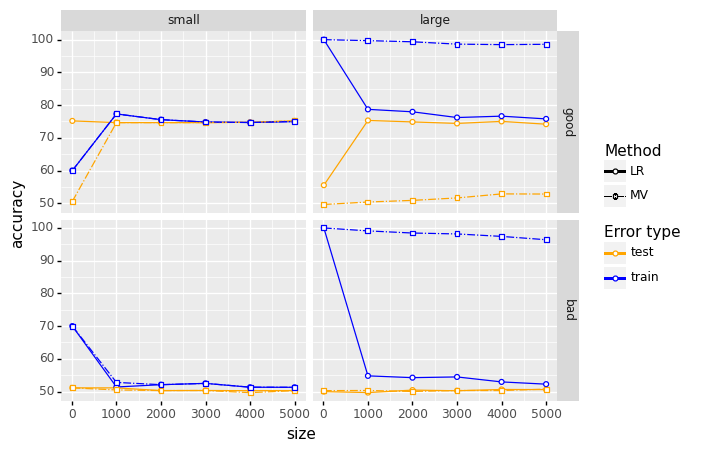

<ggplot: (395803179)>

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


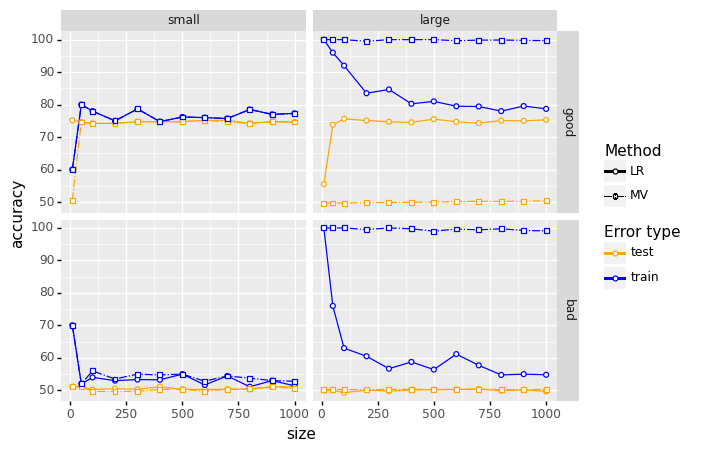

<ggplot: (396978725)>

In [25]:
# Large-scale plot
p = ggplot(data = df.loc[error['size'].isin([10, 1000, 2000, 3000, 4000, 5000]),:])
p = p + geom_line(aes(x='size', y='accuracy', linetype='method', color='type'))
p = p + geom_point(aes(x='size', y='accuracy', shape='method', color='type'), fill = 'white')
p = p + facet_grid(['fit', 'dim'])
p = p + scale_shape_manual(name='Method',values=['o', 's'], labels=['LR','MV'])
p = p + scale_linetype_manual(name = 'Method', values=['-', '-.'], labels=['LR','MV']) 
p = p + scale_color_manual(name='Error type',   values=['orange', 'blue'])
p.save('convergence-large.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Small-scale plot
p = ggplot(data = df.loc[error['size'] <= 1000,:])
p = p + geom_line(aes(x='size', y='accuracy', linetype='method', color='type'))
p = p + geom_point(aes(x='size', y='accuracy', shape='method', color='type'), fill = 'white')
p = p + facet_grid(['fit', 'dim'])
p = p + scale_shape_manual(name='Method',values=['o', 's'], labels=['LR','MV'])
p = p + scale_linetype_manual(name = 'Method', values=['-', '-.'], labels=['LR','MV']) 
p = p + scale_color_manual(name='Error type',   values=['orange', 'blue'])
p.save('convergence-small.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Homework tasks

## 1.1 Classifier that minimises empirical risk (<font color='red'>1p</font>)

Given enough information about future data samples, it is possible to find a class with optimal accuracy.
The corresponding construction `MajorityVoting` was given above for the binary classification task.
* Extend the solution for multi-label classification task and apply it to the data frame `data` below.
* Predict `z` for  `x` and `y` and show the corresponding table of rules.
* What is the corresponding risk if it is defined as the probability of misclassification on `data`? 

In [26]:
data = (DataFrame([(0, 0, 0), (0, 0, 1), (0, 0, 1), (0, 1, 2), (0, 1, 2),
                  (1, 0, 1), (1, 0, 0), (1, 0, 2), (2, 0, 1), 
                  (2, 1, 0), (2, 1, 0), (2, 1, 0), 
                  (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 2)], columns = ['x', 'y', 'z'])
        .sample(frac=1).reset_index(drop = True))
display(data.head())

,x,y,z
0,3,1,2
1,3,1,1
2,1,0,0
3,1,0,2
4,0,0,0


## 1.2 Visualise statistical fluctuations (<font color='red'>1p</font>)

The visualisations constructed above are built based on a single run where for each size we have sampled a single dataset form a data source (**distribution**). 
As such, the figure fails to capture the effect of statistical fluctuations, i.e. the effect of sampling to the results.
* Modify the code of the experiment so that 10 experiments are done for each dataset size.
* Show different scores in the graph and compute the average score line. For clarity you can do separate plots for majority voting and logistic regression.
* Justify decisions you made in the experiment design and interpret obtained results.

**Hint 1:** 
Here you must really take care of the case where a dataset contains samples with the same lable, since you do many experiments. The simplest way is to use `try-except` block for that. In case of failure you can just report `NA` as result. 

**Hint 2:**
The data generation procedure is slow as values are generated one-by-one. If you are bored or it takes too much time you can use `numpy` matrix operations to speed it up! No extra points for that.

## 1.3. Theoretical analysis of majority voting* (<font color='red'>3p</font>) 

Explain why the training accuracy is so high for majority voting. 
You can give a theoretical answer or design an experiment to answer the following questions. 
You can consider the extreme case where the features $x_i$ and labels $y$ are sampled randomly. 

* Give a rough estimate how many samples are needed to arrive to the situation where training error is roughly the same as test error. 
 
* How does the sample size depend on the number of dimensions? 
* What changes if some feature values are more probable than the others? 